In [23]:
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import laspy
import shapely
import os
from datetime import datetime
import numpy as np
from itertools import product
import math
import pyproj
import re

In [2]:
resolution = 100  #grid resolution in meters

In [3]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

lp("Starting...")

[2025-03-24 20:42:40.728753] Starting...


In [4]:
dataPath = f"{os.curdir}{os.sep}datasets{os.sep}"
lp(f"Path:  {dataPath}")

[2025-03-24 20:42:40.732279] Path:  ./datasets/


In [5]:
testLasFileName = os.listdir(f"{dataPath}laz")[5]
lp(f"Opening {testLasFileName} to get crs and more")
testLas = laspy.read(f"{dataPath}laz{os.sep}{testLasFileName}")

[2025-03-24 20:42:40.737012] Opening USGS_LPC_LA_2021GreaterNewOrleans_C22_w0819n3342.laz to get crs and more


In [6]:
neighborhoodDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson").to_crs(testLas.vlrs[0].parse_crs())

<Axes: >

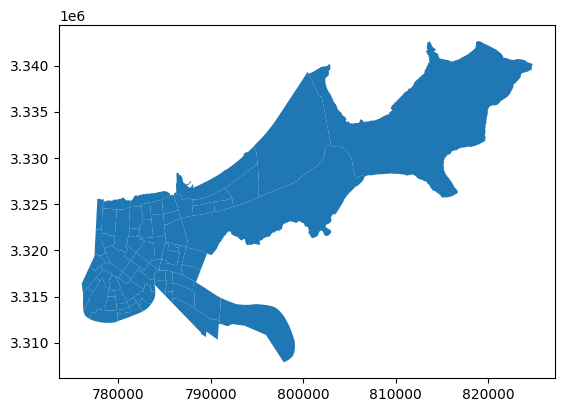

In [7]:
neighborhoodDf.plot()

In [8]:
bounds = [int(b) for b in neighborhoodDf.total_bounds]

In [9]:
xPixels = (bounds[2] - bounds[0]) / resolution
yPixels = (bounds[3] - bounds[1]) / resolution
lp(f"Resolution will be {xPixels} x {yPixels}")

[2025-03-24 20:42:41.306099] Resolution will be 488.07 x 347.58


In [10]:
boxes = [shapely.box(x,y,x+resolution,y+resolution) for x, y in product(range(bounds[0], bounds[2], resolution), range(bounds[1], bounds[3], resolution))]
boxesDf = gpd.GeoDataFrame(geometry=boxes).set_crs(neighborhoodDf.crs)
boxesDf = boxesDf[boxesDf.intersects(neighborhoodDf.union_all())].copy()
boxesDf['Altitude'] = np.nan
boxesDf['Water'] = np.nan

<Axes: >

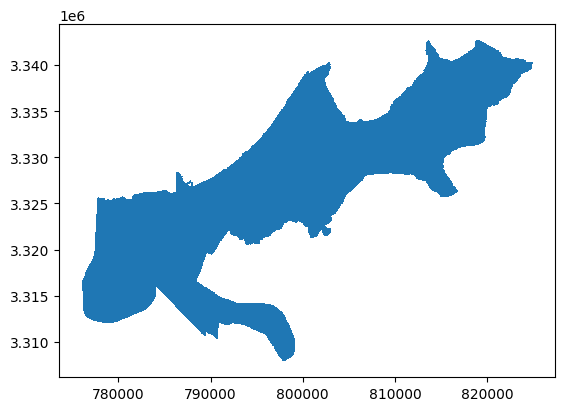

In [11]:
boxesDf.plot()


In [12]:
wgsToUTM = pyproj.transformer.Transformer.from_crs(crs_from=pyproj.CRS.from_string('WGS84'), crs_to=neighborhoodDf.crs)
meridianReg = re.compile(r'PARAMETER\["central_meridian",\-([0-9]{2})\]')
def processLas(fileName):
    las = laspy.read(fileName)
    
    assert las.vlrs[0].parse_crs() == neighborhoodDf.crs, f"CRS are not equal for {fileName}"

    central_meridian = int(meridianReg.findall(testLas.header.vlrs[0].string)[0]) * -1
        
    groundMask = np.isin(las.classification, [2,9])
    inBoundsMaskX = np.logical_and(las.X >= (bounds[0]*1000), (las.X <= (bounds[2]*1000)))
    inBoundsMaskY = np.logical_and(las.Y >= (bounds[1]*1000), (las.Y <= (bounds[3]*1000)))
    goodPointMask = np.logical_and(groundMask,inBoundsMaskX,inBoundsMaskY)
    #lp(f"{np.count_nonzero( goodPointMask )}, {np.count_nonzero( groundMask )}, {np.count_nonzero( inBoundsMaskX )} ,{np.count_nonzero( inBoundsMaskY )} in {fileName}")
    
    
    x = las.X[goodPointMask]/1000.0 #- bounds[0]
    y = (las.Y[goodPointMask]/1000.0 + wgsToUTM.transform(30,central_meridian)[1]) #- bounds[1]

    
    lasDf = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(x,y))
    lasDf['Altitude'] = las.Z[goodPointMask]
    lasDf['Class'] = las.classification[goodPointMask]
    
    return lasDf


In [44]:
def aggregateLas(lasDf):
    totalGoodPoints = 0
    for idx, row in boxesDf.iterrows():
        goodPtsMask = lasDf.intersects(row['geometry'])
        goodPtsCount = np.count_nonzero(goodPtsMask)
        totalGoodPoints += goodPtsCount
        if goodPtsCount > 0:
            boxesDf.loc[idx,'Altitude'] = lasDf.loc[goodPtsMask,'Altitude'].mean()
            waterPercent = np.count_nonzero(lasDf.loc[goodPtsMask,'Class'] == 9) / goodPtsCount * 100.0
            boxesDf.loc[idx,'Water'] = lasDf.loc[goodPtsMask,'Altitude'].mean()

    return totalGoodPoints

In [28]:
outPath = f"{os.curdir}{os.sep}output{os.sep}"
if not os.path.exists(outPath):
    lp(f"Creating output path {outPath}")
    os.makedirs(outPath)

In [46]:
for file in os.listdir(f"{dataPath}laz"):
    startTime = datetime.now()
    lasDf = processLas(f"{dataPath}laz{os.sep}{file}")
    counts = aggregateLas(lasDf)
    lp(f"{file}:  {counts} good points processed in {datetime.now()-startTime}")
    
                       

KeyboardInterrupt: 

In [ ]:
boxesDf.to_pickle(f"{outPath}AggregateLidarData.pickle")
